# Modular Neural Network Layers Demo

本 notebook 示範如何以模組化方式實作與測試神經網路 layer，方便未來擴充 CNN、GCN、Transformer、VAE 等架構。

In [1]:
import numpy as np
import sys
sys.path.append('../../models')  # 依實際路徑調整
from layers import BaseLayer, DenseLayer, build_layers_from_config, ConvLayer, GCNLayer, TransformerLayer, VAELayer

In [2]:
# BaseLayer 抽象類別設計
from abc import ABC, abstractmethod

class BaseLayer(ABC):
    def __init__(self):
        pass
    @abstractmethod
    def forward(self, X):
        pass
    @abstractmethod
    def backward(self, dA):
        pass

In [3]:
# DenseLayer 實作
class DenseLayer(BaseLayer):
    def __init__(self, in_dim, out_dim, activation):
        super().__init__()
        self.W = np.random.randn(out_dim, in_dim) * 0.01
        self.b = np.zeros((out_dim, 1))
        self.activation = activation
        self.cache = None

    def forward(self, X):
        Z = np.dot(self.W, X) + self.b
        if self.activation == 'relu':
            A = np.maximum(0, Z)
        elif self.activation == 'sigmoid':
            A = 1 / (1 + np.exp(-Z))
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")
        self.cache = (X, Z, A)
        return A

    def backward(self, dA):
        X, Z, A = self.cache
        m = X.shape[1]
        if self.activation == 'sigmoid':
            dZ = dA * A * (1 - A)
        elif self.activation == 'relu':
            dZ = dA * (Z > 0)
        else:
            raise ValueError(f"Unsupported activation: {self.activation}")
        dW = 1/m * np.dot(dZ, X.T)
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dX = np.dot(self.W.T, dZ)
        return dX, dW, db

In [4]:
# 根據 config 建立 layer list

def build_layers_from_config(layers_config):
    layers = []
    for cfg in layers_config:
        ltype = cfg['type'].lower()
        if ltype == 'dense':
            layers.append(DenseLayer(cfg['in_dim'], cfg['out_dim'], cfg['activation']))
        elif ltype == 'conv':
            layers.append(ConvLayer())  # TODO: 傳入參數
        elif ltype == 'gcn':
            layers.append(GCNLayer())   # TODO: 傳入參數
        elif ltype == 'transformer':
            layers.append(TransformerLayer())
        elif ltype == 'vae':
            layers.append(VAELayer())
        else:
            raise ValueError(f"Unknown layer type: {cfg['type']}")
    return layers

In [5]:
# 測試 DenseLayer forward/backward
np.random.seed(42)
X = np.random.randn(5, 10)  # 5 features, 10 samples
layer = DenseLayer(5, 3, 'relu')
A = layer.forward(X)
print('Forward output shape:', A.shape)

dA = np.random.randn(3, 10)
dX, dW, db = layer.backward(dA)
print('Backward dX shape:', dX.shape)
print('Backward dW shape:', dW.shape)
print('Backward db shape:', db.shape)

Forward output shape: (3, 10)
Backward dX shape: (5, 10)
Backward dW shape: (3, 5)
Backward db shape: (3, 1)


In [6]:
# 預留 CNN/GCN/Transformer/VAE layer class
class ConvLayer(BaseLayer):
    def __init__(self):
        super().__init__()
        # TODO: add parameters and implement
    def forward(self, X):
        pass
    def backward(self, dA):
        pass

class GCNLayer(BaseLayer):
    def __init__(self):
        super().__init__()
        # TODO: add parameters and implement
    def forward(self, X, A):
        pass
    def backward(self, dA):
        pass

class TransformerLayer(BaseLayer):
    def __init__(self):
        super().__init__()
        # TODO: add parameters and implement
    def forward(self, X):
        pass
    def backward(self, dA):
        pass

class VAELayer(BaseLayer):
    def __init__(self):
        super().__init__()
        # TODO: add parameters and implement
    def forward(self, X):
        pass
    def backward(self, dA):
        pass

In [7]:
# 多層 Dense Network forward/backward 示範
np.random.seed(0)
layers_config = [
    {'type': 'dense', 'in_dim': 5, 'out_dim': 8, 'activation': 'relu'},
    {'type': 'dense', 'in_dim': 8, 'out_dim': 3, 'activation': 'sigmoid'}
]
layers = build_layers_from_config(layers_config)

X = np.random.randn(5, 10)
Y = (np.random.rand(3, 10) > 0.5).astype(float)

# Forward
A = X
for layer in layers:
    A = layer.forward(A)
AL = A

# 簡單 cross-entropy cost
cost = -np.mean(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8))
print('Cost:', cost)

# Backward
# dAL: cross-entropy 對 sigmoid 輸出
m = Y.shape[1]
dAL = -(Y / (AL + 1e-8) - (1 - Y) / (1 - AL + 1e-8)) / m
dA = dAL
for layer in reversed(layers):
    dA, dW, db = layer.backward(dA)
print('Backward done.')

Cost: 0.6932205891131545
Backward done.


Test accuracy: 0.025


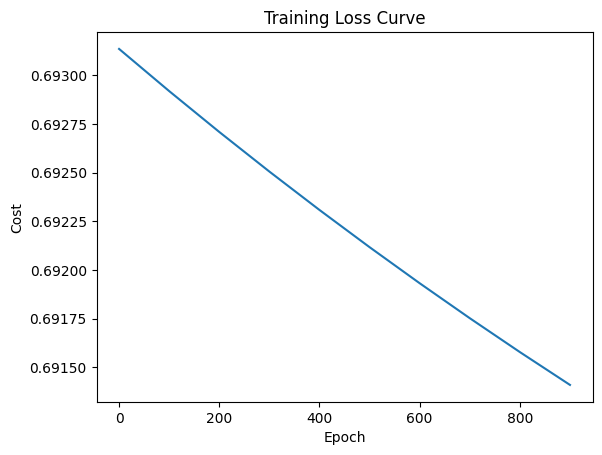

In [8]:
# 自動化多層 DNN 訓練流程（含 loss 曲線與 accuracy）
import matplotlib.pyplot as plt

np.random.seed(1)
layers_config = [
    {'type': 'dense', 'in_dim': 5, 'out_dim': 8, 'activation': 'relu'},
    {'type': 'dense', 'in_dim': 8, 'out_dim': 3, 'activation': 'sigmoid'}
]
layers = build_layers_from_config(layers_config)

# 產生 toy data
X = np.random.randn(5, 200)
Y = (np.random.rand(3, 200) > 0.5).astype(float)

# split train/test
split = 160
X_train, X_test = X[:, :split], X[:, split:]
Y_train, Y_test = Y[:, :split], Y[:, split:]

costs = []
learning_rate = 0.1
epochs = 1000
for epoch in range(epochs):
    # forward
    A = X_train
    for layer in layers:
        A = layer.forward(A)
    AL = A
    # cost
    cost = -np.mean(Y_train * np.log(AL + 1e-8) + (1 - Y_train) * np.log(1 - AL + 1e-8))
    if epoch % 100 == 0:
        costs.append(cost)
    # backward
    m = Y_train.shape[1]
    dAL = -(Y_train / (AL + 1e-8) - (1 - Y_train) / (1 - AL + 1e-8)) / m
    dA = dAL
    grads = []
    for layer in reversed(layers):
        dA, dW, db = layer.backward(dA)
        grads.insert(0, (dW, db))
    # update
    for i, layer in enumerate(layers):
        dW, db = grads[i]
        layer.W -= learning_rate * dW
        layer.b -= learning_rate * db

# 測試集評估
A = X_test
for layer in layers:
    A = layer.forward(A)
AL_test = A
y_pred = np.argmax(AL_test, axis=0)
y_true = np.argmax(Y_test, axis=0)
accuracy = np.mean(y_pred == y_true)
print(f"Test accuracy: {accuracy:.3f}")

# loss 曲線
plt.plot(np.arange(0, epochs, 100), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training Loss Curve')
plt.show()

# Data Loader 教學與強化

本節將帶你逐步理解與擴建 data_loader.py，讓它成為 ML 專案中資料處理的強大利器。

## 目標
- 熟悉現有 data_loader.py 的所有功能與用法
- 學會如何自動載入、分割、轉置、處理多種資料格式（npz/csv/npy/h5/graph）
- 逐步擴充：資料增強、標準化、toy data 生成、batch generator、EDA 等
- 打造一個可重用、可擴充、現代化的 data pipeline

## 1. 現有 data_loader.py 功能總覽

- 支援自動載入 npz/csv/npy/h5/graph 結構資料
- 可指定 key、欄位、h5 路徑等，彈性高
- 自動分割 train/test，並自動轉置成 (N, m) 格式，方便對接 numpy-from-scratch DNN
- 支援影像/張量/時序資料
- 可載入圖結構資料（adjacency matrix/edge list）

### 用法範例
```python
from data_loader import load_data
# 載入 npz 檔
x_train, x_test, y_train, y_test, N = load_data('data.npz')
# 載入 csv 檔
x_train, x_test, y_train, y_test, N = load_data('data.csv', N=20, y_cols=2)
# 載入圖結構資料
graph = load_data('graph.npz', graph_key='adj')
```

接下來會逐步帶你實作與測試每一個功能。

### 2. npz 檔案自動載入功能實測

本節將實際操作 data_loader.py 的 npz 檔案自動載入功能，讓你熟悉其用法與行為。

**步驟：**
1. 準備一個 toy npz 檔案（含 X, Y 資料）
2. 用 `load_data` 載入，觀察自動分割、轉置、回傳格式
3. 檢查 shape、內容、N 值

（如無現成 npz，可用下方 code cell 產生 toy npz 檔）

In [13]:
# 產生 toy npz 檔案供測試
import numpy as np

X = np.random.randn(100, 5)  # 100 筆資料, 5 features
Y = (np.random.rand(100, 1) > 0.5).astype(int)  # 100 筆二元標籤

np.savez('toy_data.npz', X=X, Y=Y)
print('toy_data.npz 已產生，內容 shape:', X.shape, Y.shape)

toy_data.npz 已產生，內容 shape: (100, 5) (100, 1)


In [ ]:
# 用 data_loader 載入 toy_data.npz，檢查 shape 與內容
import sys
sys.path.append('../../archive/from_scratch')  # 根據實際路徑調整
from data_loader import load_data

x_train, x_test, y_train, y_test, N = load_data('toy_data.npz')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('N:', N)

# 檢查部分內容
print('x_train[0]:', x_train[0])
print('y_train[0]:', y_train[0])

> 執行上方 cell，觀察 x_train/x_test/y_train/y_test/N 的 shape 與內容，理解 data_loader.py 的自動分割、轉置、回傳格式。
- 預設會自動將資料分割為 train/test，並將 shape 轉為 (N, m) 方便 DNN 使用。
- 若 npz 檔有多個 key，可用 `x_key`, `y_key` 參數自訂。

下一步：
- 可嘗試自訂 key、調整 N、或測試其他格式（csv/npy/h5/graph）